## Transformer Tutorial

This code demonstrates a Transformer-based weather forecasting model implemented in PyTorch, using xarray's 'air_temperature' tutorial dataset. While the implementation is technically sophisticated, combining a Transformer encoder-decoder architecture with specialized 2D positional encodings to handle geographical data, the small dataset size (split 80-20 for training-validation) makes this approach suboptimal for practical use.

The model processes sequences of 20 timesteps to predict 2 future timesteps, with a 2-timestep gap between input and prediction. Its architecture allows it to capture both spatial and temporal dependencies in weather patterns simultaneously through attention mechanisms and skip connections. However, this sophistication comes at a cost - the model is computationally intensive and memory-hungry due to its attention mechanisms, and its complexity may lead to overfitting on such a limited dataset.

For this particular demonstration case, simpler architectures like U-Net or CNN would likely be more appropriate. These models inherently handle spatial relationships through their structure and can learn effective representations even from smaller datasets. U-Net's encoder-decoder architecture with skip connections would be particularly well-suited for maintaining spatial resolution while capturing both local and global temperature patterns. The Transformer architecture shown here would become more relevant with a much larger dataset, perhaps combining multiple years of global satellite observations or climate model outputs, where its ability to learn long-range dependencies could be fully utilized. However, for this tutorial-sized dataset, the complexity of the Transformer architecture outweighs its benefits, making simpler neural network architectures a more practical choice.

In [1]:
!pip install cmocean metpy cartopy

In [2]:
# Standard imports for data handling and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F  # Add this import

import math
import xarray as xr
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import colortables
import metpy.calc as mpcalc
from metpy.units import units
import cmocean  # Colormaps specifically designed for oceanography/meteorology

## Functions

This dataset class is designed for training machine learning models to perform weather forecasting. It takes weather data stored in an xarray DataArray format and creates sequences of input-output pairs for training. The class implements a sliding window approach where each sample consists of a sequence of historical weather data (input) and the corresponding future weather conditions to be predicted (output). The data can be normalized, and users can specify various parameters like the length of input and output sequences, a gap between them, and the stride for creating overlapping sequences. The class handles the complexity of properly indexing the time dimension and converting the data into PyTorch tensors with the appropriate shape for training deep learning models. This implementation is particularly useful for spatiotemporal forecasting tasks where you need to predict weather patterns across a geographic grid over time.

In [3]:
class WeatherForecastDataset(Dataset):
    def __init__(self, da: xr.DataArray,
                 input_length: int = 10,   # Number of timesteps to use as input
                 output_length: int = 4,    # Number of timesteps to predict
                 gap: int = 0,             # Optional gap between input and prediction
                 stride: int = 1,          # Step size between samples
                 normalize: bool = True):   # Whether to normalize the data
        # Store the xarray DataArray and configuration parameters
        self.data = da
        self.input_length = input_length
        self.output_length = output_length
        self.gap = gap
        self.stride = stride
        # Total sequence length including input, gap, and output
        self.total_length = input_length + gap + output_length

        # Normalize the data using mean and standard deviation if requested
        if normalize:
            self.mean = float(da.mean())
            self.std = float(da.std())
            self.data = (da - self.mean) / self.std

        # Calculate valid starting indices for sequences
        # Ensures we don't try to access beyond the data's end
        self.valid_indices = range(0,
                                 len(da.time) - self.total_length + 1,
                                 stride)

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Get the starting index for this sequence
        start_idx = self.valid_indices[idx]

        # Create slices for input and target sequences
        # Input slice takes the first input_length timesteps
        # Target slice starts after the gap and takes output_length timesteps
        input_slice = slice(start_idx, start_idx + self.input_length)
        target_slice = slice(start_idx + self.input_length + self.gap,
                           start_idx + self.input_length + self.gap + self.output_length)

        # Extract the sequences from the data
        input_seq = self.data.isel(time=input_slice)
        target_seq = self.data.isel(time=target_slice)

        # Convert to PyTorch tensors and rearrange dimensions
        # Changes from (time, lat, lon) to (lat, lon, time) format
        return (torch.from_numpy(input_seq.values).float().permute(1, 2, 0),
                torch.from_numpy(target_seq.values).float().permute(1, 2, 0))

This class implements a crucial component for transformer models working with 2D spatial data, such as images or geographic information. Traditional transformers lose spatial information when flattening 2D data into sequences. This positional encoding addresses that limitation by embedding precise location information into each position in a 2D grid. It works by creating a unique "spatial signature" for each (x,y) coordinate using carefully designed sinusoidal patterns at different frequencies. When added to the input features, these encodings allow the transformer's attention mechanisms to consider spatial relationships while processing the data. This is particularly valuable in tasks like image analysis, satellite imagery processing, or any application where maintaining awareness of spatial relationships is important for accurate predictions.

In [4]:
class PositionalEncoding2D(nn.Module):
    """2D positional encoding for transformer models working with spatial data.

    Creates unique positional embeddings for each location in a 2D grid using
    sinusoidal patterns at different frequencies for height and width dimensions.

    Args:
        d_model (int): Feature dimension (must be even)
        max_h (int): Maximum height of input grid (default: 100)
        max_w (int): Maximum width of input grid (default: 100)
    """
    def __init__(self, d_model: int, max_h: int = 100, max_w: int = 100):
        super().__init__()
        assert d_model % 2 == 0, "d_model must be even"

        # Create position indices and frequency bands
        pos_h = torch.arange(max_h).unsqueeze(1).float()
        pos_w = torch.arange(max_w).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model//2, 2).float() *
                           (-math.log(10000.0) / d_model))

        # Generate encodings for height and width separately
        pe_h = torch.zeros(max_h, d_model//2)
        pe_w = torch.zeros(max_w, d_model//2)

        # Apply sinusoidal patterns
        pe_h[:, 0::2], pe_h[:, 1::2] = torch.sin(pos_h * div_term), torch.cos(pos_h * div_term)
        pe_w[:, 0::2], pe_w[:, 1::2] = torch.sin(pos_w * div_term), torch.cos(pos_w * div_term)

        # Combine into 2D positional encoding
        self.register_buffer('pe', torch.cat([
            pe_h.unsqueeze(1).expand(-1, max_w, -1),
            pe_w.unsqueeze(0).expand(max_h, -1, -1)
        ], dim=-1))

    def forward(self, x):
        """Add positional encoding to input tensor."""
        return x + self.pe[:x.size(1), :x.size(2)]

The WeatherTransformer architecture combines standard PyTorch transformer components with specialized elements for handling spatial weather data. At its foundation, the model uses learnable parameters for input transformation through nn.Linear layers. The input projection converts time dimensions to the model's working dimension, while temporal embeddings (created as nn.Parameters with random initialization) provide crucial positional information for both input and output sequences.

A distinguishing feature is the custom PositionalEncoding2D class, which creates unique positional encodings for each location in the 2D grid using sinusoidal patterns. Unlike standard transformer positional encodings designed for sequences, this approach allows the model to understand both latitude and longitude positions simultaneously.

The transformer's core utilizes PyTorch's nn.TransformerEncoderLayer and nn.TransformerDecoderLayer components, configured with specified numbers of attention heads and feedforward dimensions. These layers are set up with batch_first=True to handle input in the shape (batch, sequence, features). The implementation incorporates clever skip connections through additional nn.Linear layers, preserving both temporal and spatial information that might otherwise be lost in the attention mechanisms.

The forward pass occurs in two stages. During encoding, the model flattens spatial dimensions, applies positional encoding, and prepares data for transformer layers using reshape operations. The decoding stage then uses the encoded memory as context for generating predictions, with output temporal embeddings helping structure the prediction sequence.

What makes this implementation particularly effective for weather data is how it maintains spatial structure throughout the transformer operations, which traditionally excel at sequential rather than spatial data. The combination of 2D positional encodings and skip connections enables the model to learn both local and global patterns in temperature data effectively. The architecture creates a sophisticated balance between preserving spatial relationships while leveraging the transformer's powerful attention mechanisms for capturing long-range dependencies in both space and time.

In [5]:
class WeatherTransformer(nn.Module):
    """Transformer model for weather forecasting using spatiotemporal data.

    This model combines positional encoding, transformer encoder-decoder architecture,
    and skip connections to process and predict weather patterns over time and space.

    Args:
        input_dim (int): Number of input features
        input_length (int): Number of input timesteps (default: 10)
        output_length (int): Number of timesteps to predict (default: 4)
        d_model (int): Hidden dimension of transformer (default: 256)
        nhead (int): Number of attention heads (default: 8)
        num_encoder_layers (int): Number of transformer encoder layers (default: 6)
        num_decoder_layers (int): Number of transformer decoder layers (default: 6)
        dim_feedforward (int): Dimension of feedforward network (default: 1024)
        dropout (float): Dropout rate (default: 0.1)
        max_h (int): Maximum height of spatial grid (default: 100)
        max_w (int): Maximum width of spatial grid (default: 100)
        verbose (bool): Whether to print debug information (default: False)
    """
    def __init__(self,
                 input_dim: int,
                 input_length: int = 10,
                 output_length: int = 4,
                 d_model: int = 256,
                 nhead: int = 8,
                 num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6,
                 dim_feedforward: int = 1024,
                 dropout: float = 0.1,
                 max_h: int = 100,
                 max_w: int = 100,
                 verbose: bool = False):
        super().__init__()

        assert d_model % nhead == 0, "d_model must be divisible by nhead"

        self.input_length = input_length
        self.output_length = output_length
        self.d_model = d_model
        self.verbose = verbose

        # Initialize model components (projections, embeddings, and transformer layers)
        self.input_projection = nn.Linear(input_length, d_model)
        self.temporal_embedding = nn.Parameter(torch.randn(input_length, d_model))
        self.output_temporal_embedding = nn.Parameter(torch.randn(output_length, d_model))
        self.pos_encoder = PositionalEncoding2D(d_model, max_h, max_w)

        # Skip connections for preserving spatial and temporal information
        self.input_skip = nn.Linear(input_length, output_length)
        self.spatial_skip = nn.Linear(d_model, d_model)

        # Initialize transformer encoder-decoder architecture
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoder_layers
        )

        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=num_decoder_layers
        )

        self.output_projection = nn.Linear(d_model, 1)

    def encode(self, x):
        """Process input sequence through transformer encoder.

        Args:
            x (Tensor): Input tensor [batch, height, width, time]
        Returns:
            Tuple of (encoded memory, spatial dimensions, skip connection)
        """
        b, h, w, t = x.shape
        if self.verbose:
            print(f"\nEncoder shapes:")
            print(f"Input shape: {x.shape}")

        # Process input through projections and positional encoding
        x_flat = x.reshape(b * h * w, t)
        input_skip = self.input_skip(x_flat).reshape(b, h, w, -1)
        x_proj = self.input_projection(x_flat)
        x_reshaped = x_proj.reshape(b, h, w, self.d_model)
        x_pos = self.pos_encoder(x_reshaped)
        x_transformer = x_pos.reshape(b, h * w, self.d_model)

        # Apply transformer encoding with skip connection
        memory = self.transformer_encoder(x_transformer)
        spatial_skip = self.spatial_skip(x_transformer)
        memory = memory + spatial_skip

        return memory, (b, h, w), input_skip

    def decode(self, memory, spatial_dims, input_skip):
        """Generate predictions from encoded memory.

        Args:
            memory (Tensor): Encoded memory from transformer encoder
            spatial_dims (tuple): Original spatial dimensions (batch, height, width)
            input_skip (Tensor): Skip connection from encoder
        Returns:
            Tensor: Predictions [batch, height, width, output_length]
        """
        b, h, w = spatial_dims

        # Generate predictions through transformer decoder
        tgt = self.output_temporal_embedding.unsqueeze(0).expand(b, -1, -1)
        decoder_output = self.transformer_decoder(tgt, memory)

        # Reshape and project to final output
        decoder_spatial = decoder_output.unsqueeze(2).expand(-1, -1, h*w, -1)
        flat_spatial = decoder_spatial.permute(0, 2, 1, 3).reshape(-1, self.d_model)
        projected = self.output_projection(flat_spatial)
        output = projected.reshape(b, h, w, self.output_length)

        return output + input_skip

    def forward(self, x):
        """Forward pass through the model."""
        memory, spatial_dims, input_skip = self.encode(x)
        return self.decode(memory, spatial_dims, input_skip)

In [6]:
def custom_loss(predictions, targets, lambda_std=0.1):
    """
    Custom loss function combining RMSE with standard deviation matching.

    The function handles two key aspects of the prediction quality:
    1. Accuracy: Through RMSE calculation
    2. Variability: Through standard deviation matching

    The tensors have shape [batch_size, height, width, features], and we want
    to preserve the spatial information while calculating statistics.

    Args:
        predictions (torch.Tensor): Model predictions
        targets (torch.Tensor): Ground truth values
        lambda_std (float): Weight for standard deviation term

    Returns:
        tuple: (total_loss, loss_components_dict)
    """
    # Calculate RMSE component - this measures prediction accuracy
    mse = torch.mean((predictions - targets) ** 2)
    rmse_loss = torch.sqrt(mse)

    # Calculate standard deviation component
    # We'll calculate std over the batch dimension (dim=0) and average over spatial dimensions
    # unbiased=False removes the Bessel correction and addresses the warning
    pred_std = torch.std(predictions, dim=0, unbiased=False)
    target_std = torch.std(targets, dim=0, unbiased=False)

    # Average the standard deviation differences across spatial dimensions
    std_loss = torch.mean(torch.abs(pred_std - target_std))

    # Combine the losses with the weighting factor
    total_loss = rmse_loss + lambda_std * std_loss

    # Store components for monitoring
    loss_components = {
        'rmse': rmse_loss.item(),
        'std_diff': std_loss.item(),
        'total': total_loss.item()
    }

    return total_loss, loss_components

In [7]:
def evaluate_model(model, dataloader, dataset, device, loss_fn):
    """
    Evaluates the model on the given dataset, computing various metrics.

    Args:
        model: The neural network model
        dataloader: DataLoader containing the dataset
        dataset: The dataset object
        device: Device to run computations on (cuda/cpu)
        loss_fn: Custom loss function that returns loss and components

    Returns:
        dict: Dictionary containing various evaluation metrics
    """
    total_loss = 0
    all_preds = []
    all_targets = []
    loss_components = {'rmse': 0, 'std_diff': 0, 'total': 0}

    for batch in dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        # Get model predictions
        predictions = model(inputs)

        # Calculate loss and components
        loss, batch_components = loss_fn(predictions, targets)

        # Accumulate loss components
        for key in loss_components:
            loss_components[key] += batch_components[key]

        # Store predictions and targets for later analysis
        all_preds.append(predictions.detach())
        all_targets.append(targets.detach())

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate average metrics
    num_batches = len(dataloader)
    metrics = {
        'loss': loss_components['total'] / num_batches,
        'rmse': loss_components['rmse'] / num_batches,
        'pred_std': torch.std(all_preds).item(),
        'target_std': torch.std(all_targets).item(),
        'preds': all_preds,
        'targets': all_targets
    }

    return metrics

## Running the Model

In [8]:
air_temp = xr.tutorial.load_dataset('air_temperature')

# Extract the DataArray from the Dataset
# The 'air' variable contains the temperature measurements
da = air_temp.air

# Print information about the dataset to understand its structure
print("Dataset Information:")
print(f"Dimensions: {da.dims}")
print(f"Time range: {da.time[0].values} to {da.time[-1].values}")
print(f"Latitude range: {da.lat.min().values}°N to {da.lat.max().values}°N")
print(f"Longitude range: {da.lon.min().values}°E to {da.lon.max().values}°E")
print(f"Total timesteps: {len(da.time)}")


Dataset Information:
Dimensions: ('time', 'lat', 'lon')
Time range: 2013-01-01T00:00:00.000000000 to 2014-12-31T18:00:00.000000000
Latitude range: 15.0°N to 75.0°N
Longitude range: 200.0°E to 330.0°E
Total timesteps: 2920


In [9]:
# First, let's determine the split point for our data
total_timesteps = len(da.time)
train_size = int(0.8 * total_timesteps)

# Create separate DataArrays for training and validation
# We split along the time dimension to maintain temporal structure
da_train = da.isel(time=slice(0, train_size))
da_val = da.isel(time=slice(train_size, None))

# Create training dataset first with normalization enabled
train_dataset = WeatherForecastDataset(
    da_train,
    input_length=20,
    output_length=2,
    gap=2,
    stride=1,
    normalize=True  # Enable normalization for training set
)

# Create validation dataset with normalization enabled
val_dataset = WeatherForecastDataset(
    da_val,
    input_length=20,
    output_length=2,
    gap=2,
    stride=1,
    normalize=True  # Enable normalization for validation set
)

# Now we need to ensure the validation set uses the training set's normalization statistics
# This is crucial because in real-world scenarios, we won't have future data statistics
val_dataset.mean = train_dataset.mean  # Use training mean
val_dataset.std = train_dataset.std    # Use training standard deviation

# Manually normalize the validation data using training statistics
val_dataset.data = (da_val - train_dataset.mean) / train_dataset.std

# Create dataloaders with appropriate settings for training and validation
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True  # Shuffle training data for better generalization
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False  # Don't shuffle validation data to maintain temporal order
)

# Print dataset sizes and normalization statistics to verify the setup
print(f"Training set size: {len(train_dataset)} sequences")
print(f"Validation set size: {len(val_dataset)} sequences")
print(f"\nNormalization statistics from training set:")
print(f"Mean: {train_dataset.mean:.4f}")
print(f"Standard deviation: {train_dataset.std:.4f}")

Training set size: 2313 sequences
Validation set size: 561 sequences

Normalization statistics from training set:
Mean: 280.9292
Standard deviation: 16.4165


In [10]:
# Initialize the model with parameters matching your data dimensions
# Get the spatial dimensions from your dataset
lat_size = len(da.lat)
lon_size = len(da.lon)

# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")

# Initialize the model
model = WeatherTransformer(
    input_dim=1,              # Single feature (temperature)
    input_length=20,          # Matches input_length from dataset
    output_length=2,          # Matches output_length from dataset
    d_model=256,             # Size of the transformer's hidden dimension
    nhead=8,                 # Number of attention heads (must divide d_model evenly)
    num_encoder_layers=4,    # Number of transformer encoder layers
    num_decoder_layers=4,    # Number of transformer decoder layers
    dim_feedforward=512,    # Dimension of feedforward network
    dropout=0.1,             # Dropout rate for regularization
    max_h=lat_size,          # Maximum height (latitude dimension)
    max_w=lon_size,          # Maximum width (longitude dimension)
    verbose=False            # Set to True for debugging information
).to(device)                 # Move model to GPU if available

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print("\nModel Configuration:")
print(f"Input dimension: 1 (temperature)")
print(f"Spatial dimensions: {lat_size}x{lon_size}")
print(f"Input sequence length: 20")
print(f"Output sequence length: 2")
print(f"Model hidden dimension: 256")
print(f"Number of attention heads: 8")
print(f"Number of encoder/decoder layers: 6")
print(f"Using device: {device}")

# Verify a forward pass with a sample batch
with torch.no_grad():
    sample_batch = next(iter(train_dataloader))
    sample_input, _ = sample_batch
    sample_input = sample_input.to(device)
    try:
        sample_output = model(sample_input)
        print("\nModel forward pass successful!")
        print(f"Input shape: {sample_input.shape}")
        print(f"Output shape: {sample_output.shape}")
    except Exception as e:
        print("\nError during forward pass:")
        print(e)

Using device: cuda
GPU Device Name: Tesla T4
Memory Allocated: 0.00 GB

Model Configuration:
Input dimension: 1 (temperature)
Spatial dimensions: 25x53
Input sequence length: 20
Output sequence length: 2
Model hidden dimension: 256
Number of attention heads: 8
Number of encoder/decoder layers: 6
Using device: cuda

Model forward pass successful!
Input shape: torch.Size([4, 25, 53, 20])
Output shape: torch.Size([4, 25, 53, 2])


In [11]:
# Initialize metrics dictionary to track training progress
metrics = {
    'train_loss': [],       # Training loss history
    'train_rmse': [],       # Training RMSE in degrees Celsius
    'train_pred_std': [],   # How varied the model's training predictions are
    'train_target_std': [], # How varied the actual training data is
    'val_loss': [],         # Validation loss history
    'val_rmse': [],         # Validation RMSE in degrees Celsius
    'val_pred_std': [],     # How varied the model's validation predictions are
    'val_target_std': []    # How varied the actual validation data is
}

# Training loop configuration
num_epochs = 30
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait before early stopping
patience_counter = 0

print("Starting training process...")

# Main training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    epoch_train_losses = []  # Track losses for this epoch

    # Iterate through batches of training data
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        # Move data to correct device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss using custom loss function
        loss, loss_components = custom_loss(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Store batch loss
        epoch_train_losses.append(loss_components)

    # Calculate average training metrics for this epoch
    avg_train_metrics = {
        'loss': np.mean([x['total'] for x in epoch_train_losses]),
        'rmse': np.mean([x['rmse'] for x in epoch_train_losses])
    }

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_losses = []

    with torch.no_grad():  # No need to track gradients during validation
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss, loss_components = custom_loss(outputs, targets)
            val_losses.append(loss_components)

    # Calculate average validation metrics
    avg_val_metrics = {
        'loss': np.mean([x['total'] for x in val_losses]),
        'rmse': np.mean([x['rmse'] for x in val_losses])
    }

    # Store metrics for this epoch
    metrics['train_loss'].append(avg_train_metrics['loss'])
    metrics['train_rmse'].append(avg_train_metrics['rmse'] * train_dataset.std)  # Convert to °C
    metrics['val_loss'].append(avg_val_metrics['loss'])
    metrics['val_rmse'].append(avg_val_metrics['rmse'] * train_dataset.std)  # Convert to °C

    if (epoch + 1) % 3 == 0:
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_metrics["loss"]:.4f}, '
              f'Validation Loss: {avg_val_metrics["loss"]:.4f}')
        print(f'Training RMSE: {metrics["train_rmse"][-1]:.2f}°C, '
              f'Validation RMSE: {metrics["val_rmse"][-1]:.2f}°C')

        # Sample point prediction comparison
        sample_point = (12, 25)  # This represents lat=12, lon=25 in our grid
        print(f'\nMonitoring grid point (lat={sample_point[0]}, lon={sample_point[1]}):')

        with torch.no_grad():
            # Get a sample batch and its targets
            sample_batch = next(iter(train_dataloader))
            sample_input, sample_target = sample_batch[0][:1].to(device), sample_batch[1][:1].to(device)
            sample_output = model(sample_input)

            # Convert predictions and targets to actual temperatures
            pred_temp = (sample_output[0, sample_point[0], sample_point[1]] * train_dataset.std
                        + train_dataset.mean).cpu().numpy()
            true_temp = (sample_target[0, sample_point[0], sample_point[1]] * train_dataset.std
                        + train_dataset.mean).cpu().numpy()

            # Calculate standard deviations in actual temperature units
            pred_std = sample_output.std().item() * train_dataset.std
            target_std = sample_target.std().item() * train_dataset.std

            print('\nPredictions and Actual Values:')
            for timestep in range(2):
                print(f'  Timestep {timestep+1}:')
                print(f'    Predicted: {pred_temp[timestep]:.2f}°C')
                print(f'    Actual: {true_temp[timestep]:.2f}°C')
                print(f'    Difference: {abs(pred_temp[timestep] - true_temp[timestep]):.2f}°C')

            print('\nVariability Statistics:')
            print(f'  Prediction Standard Deviation: {pred_std:.2f}°C')
            print(f'  Actual Standard Deviation: {target_std:.2f}°C')

    # Early stopping check
    if avg_val_metrics['loss'] < best_val_loss:
        best_val_loss = avg_val_metrics['loss']
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        print(f'Best validation loss: {best_val_loss:.4f}')
        break

print("\nTraining completed!")
print(f"Best validation loss achieved: {best_val_loss:.4f}")

# Convert metrics to numpy arrays for plotting
metrics = {k: np.array(v) for k, v in metrics.items()}

Starting training process...

Epoch 3/30:
Training Loss: 0.1938, Validation Loss: 0.1855
Training RMSE: 3.08°C, Validation RMSE: 2.99°C

Monitoring grid point (lat=12, lon=25):

Predictions and Actual Values:
  Timestep 1:
    Predicted: 272.35°C
    Actual: 261.90°C
    Difference: 10.45°C
  Timestep 2:
    Predicted: 274.28°C
    Actual: 258.90°C
    Difference: 15.38°C

Variability Statistics:
  Prediction Standard Deviation: 20.51°C
  Actual Standard Deviation: 21.11°C

Epoch 6/30:
Training Loss: 0.1860, Validation Loss: 0.1771
Training RMSE: 2.95°C, Validation RMSE: 2.85°C

Monitoring grid point (lat=12, lon=25):

Predictions and Actual Values:
  Timestep 1:
    Predicted: 294.47°C
    Actual: 293.90°C
    Difference: 0.57°C
  Timestep 2:
    Predicted: 293.42°C
    Actual: 293.50°C
    Difference: 0.08°C

Variability Statistics:
  Prediction Standard Deviation: 9.40°C
  Actual Standard Deviation: 9.42°C

Epoch 9/30:
Training Loss: 0.1839, Validation Loss: 0.1782
Training RMSE: 2.

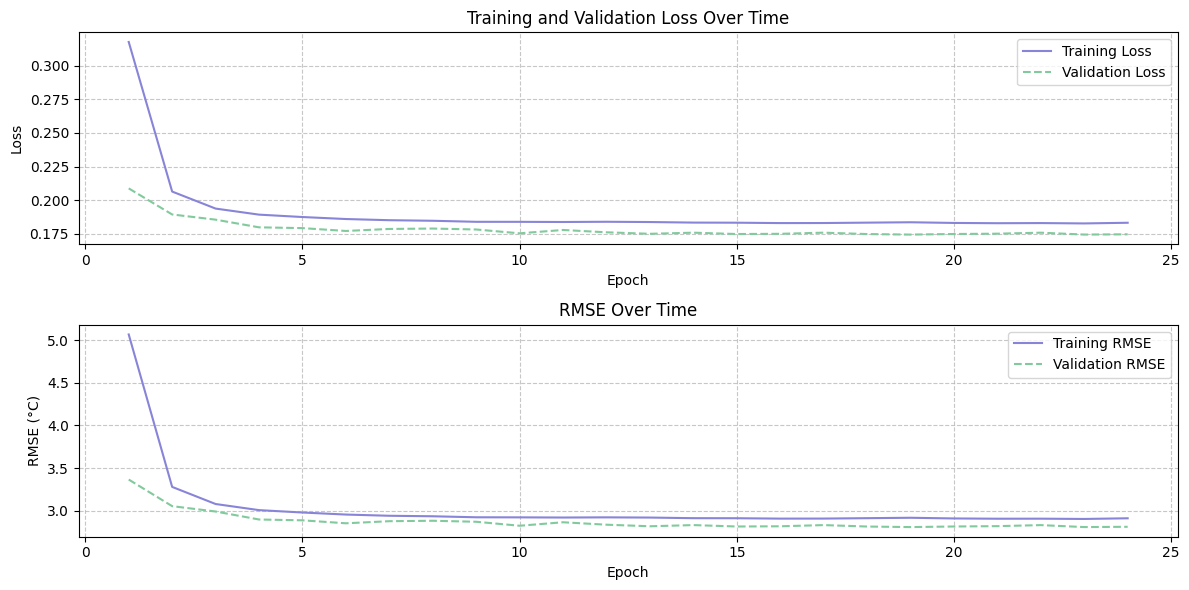

In [17]:
# Create figure with three subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
fig.tight_layout(pad=3.0)  # Add space between subplots

# Calculate the number of epochs from any metric array
epochs = range(1, len(metrics['train_loss']) + 1)

# Plot 1: Training and Validation Loss
ax1.plot(epochs, metrics['train_loss'], color='#8884d8', label='Training Loss')
ax1.plot(epochs, metrics['val_loss'], color='#82ca9d', label='Validation Loss', linestyle='--')
ax1.set_title('Training and Validation Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot 2: Training and Validation RMSE
ax2.plot(epochs, metrics['train_rmse'], color='#8884d8', label='Training RMSE')
ax2.plot(epochs, metrics['val_rmse'], color='#82ca9d', label='Validation RMSE', linestyle='--')
ax2.set_title('RMSE Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE (°C)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
def visualize_prediction_sequence(model, dataset, dataloader, device, sample_idx=0):
    """
    Creates a visualization comparing model predictions with actual values.

    Args:
        model: Trained WeatherTransformer model
        dataset: WeatherForecastDataset instance
        dataloader: DataLoader instance
        device: torch device
        sample_idx: Index of the sample to visualize
    """
    model.eval()

    # Get predictions
    inputs, targets = dataset[sample_idx]
    with torch.no_grad():
        predictions = model(inputs.unsqueeze(0).to(device))

    # Denormalize data
    inputs = inputs.cpu().numpy() * dataset.std + dataset.mean
    targets = targets.cpu().numpy() * dataset.std + dataset.mean
    predictions = predictions.cpu().numpy()[0] * dataset.std + dataset.mean

    # Setup visualization
    fig = plt.figure(figsize=(20, 12))
    n_input, n_output = inputs.shape[-1], targets.shape[-1]
    total_steps = n_input + 2 + n_output

    # Configure map and temperature display
    vmin, vmax = min(inputs.min(), targets.min(), predictions.min()), max(inputs.max(), targets.max(), predictions.max())
    # Balanced number of contour levels for detail while maintaining clarity
    levels = np.linspace(vmin, vmax, 10)

    for t in range(total_steps):
        ax = fig.add_subplot(4, 6, t + 1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='50m', color='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        # Calculate map boundaries with inset margins
        lon_min, lon_max = float(dataset.data.lon.min()), float(dataset.data.lon.max())
        lat_min, lat_max = float(dataset.data.lat.min()), float(dataset.data.lat.max())

        # Create asymmetric inset - trim more from northern extent
        inset = 5
        north_inset = 15  # Increased trimming for northern boundary
        lat_max = min(65, lat_max - north_inset)  # More aggressive northern trim
        lat_min = max(-75, lat_min + inset)  # Keep same southern extent
        lon_min += inset
        lon_max -= inset

        ax.set_extent([lon_min, lon_max, lat_min, lat_max])

        if t < n_input:  # Historical data
            data = inputs[:, :, t]
            hours_ago = (n_input - t) * 6
            title = f'Training Sequence\nt-{hours_ago}h\n{data.mean():.1f}K'
            # Add contours to historical data
            ax.contour(dataset.data.lon, dataset.data.lat, data,
                      levels=levels, colors='black', alpha=0.3,
                      transform=ccrs.PlateCarree())

        elif t < n_input + 2:  # GAP frames
            weight = (t - n_input) / 2
            data = (1 - weight) * inputs[:, :, -1] + weight * predictions[:, :, 0]
            title = f'Not Used for Training\nGAP\nt+{(t-n_input)*6}h'
            # Add interpolated contours in gap
            ax.contour(dataset.data.lon, dataset.data.lat, data,
                      levels=levels, colors='black', alpha=0.3,
                      transform=ccrs.PlateCarree())

        else:  # Predictions vs truth
            pred_idx = t - (n_input + 2)
            pred_data = predictions[:, :, pred_idx]
            true_data = targets[:, :, pred_idx]
            data = pred_data

            # Calculate metrics
            rmse = np.sqrt(np.mean((pred_data - true_data) ** 2))
            corr = np.corrcoef(pred_data.flatten(), true_data.flatten())[0, 1]

            title = (f'Predictions\nt+{(pred_idx+2)*6}h\n'
                    f'True: {true_data.mean():.1f}K\n'
                    f'Pred: {pred_data.mean():.1f}K\n'
                    f'RMSE: {rmse:.2f}K')

            # Add truth contours
            ax.contour(dataset.data.lon, dataset.data.lat, true_data,
                      levels=levels, colors='black', alpha=0.3,
                      transform=ccrs.PlateCarree())

        # Plot data
        mesh = ax.pcolormesh(dataset.data.lon, dataset.data.lat, data,
                           transform=ccrs.PlateCarree(),
                           cmap='YlGnBu_r', vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=8, pad=4)
        ax.set_xticks([])
        ax.set_yticks([])

    # Add colorbar and title
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(mesh, cax=cbar_ax, label='Temperature (K)')
    plt.suptitle(f'Temperature Prediction Sequence - Sample {sample_idx}',
                y=0.95, fontsize=16)

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.05, right=0.9,
                       wspace=0.1, hspace=0.2)
    plt.show()

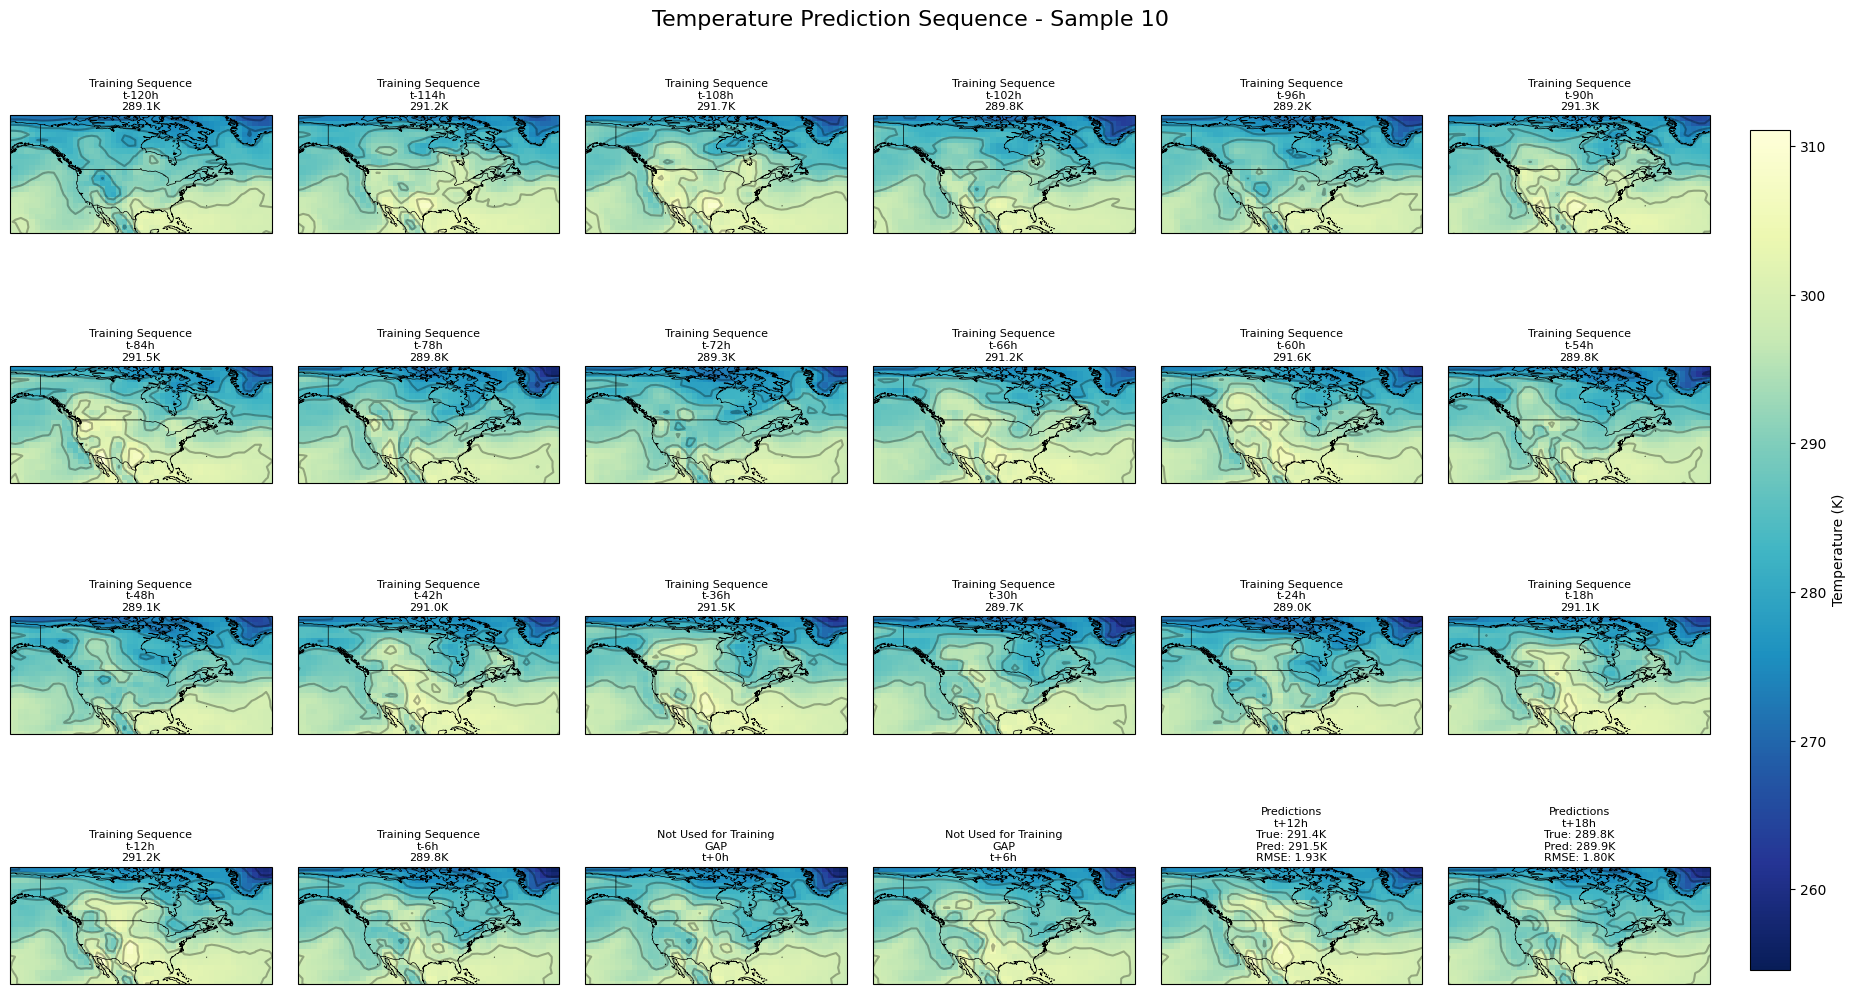

In [20]:
visualize_prediction_sequence(
    model=model,
    dataset=val_dataset,
    dataloader=val_dataloader,
    device=device,
    sample_idx=10
)


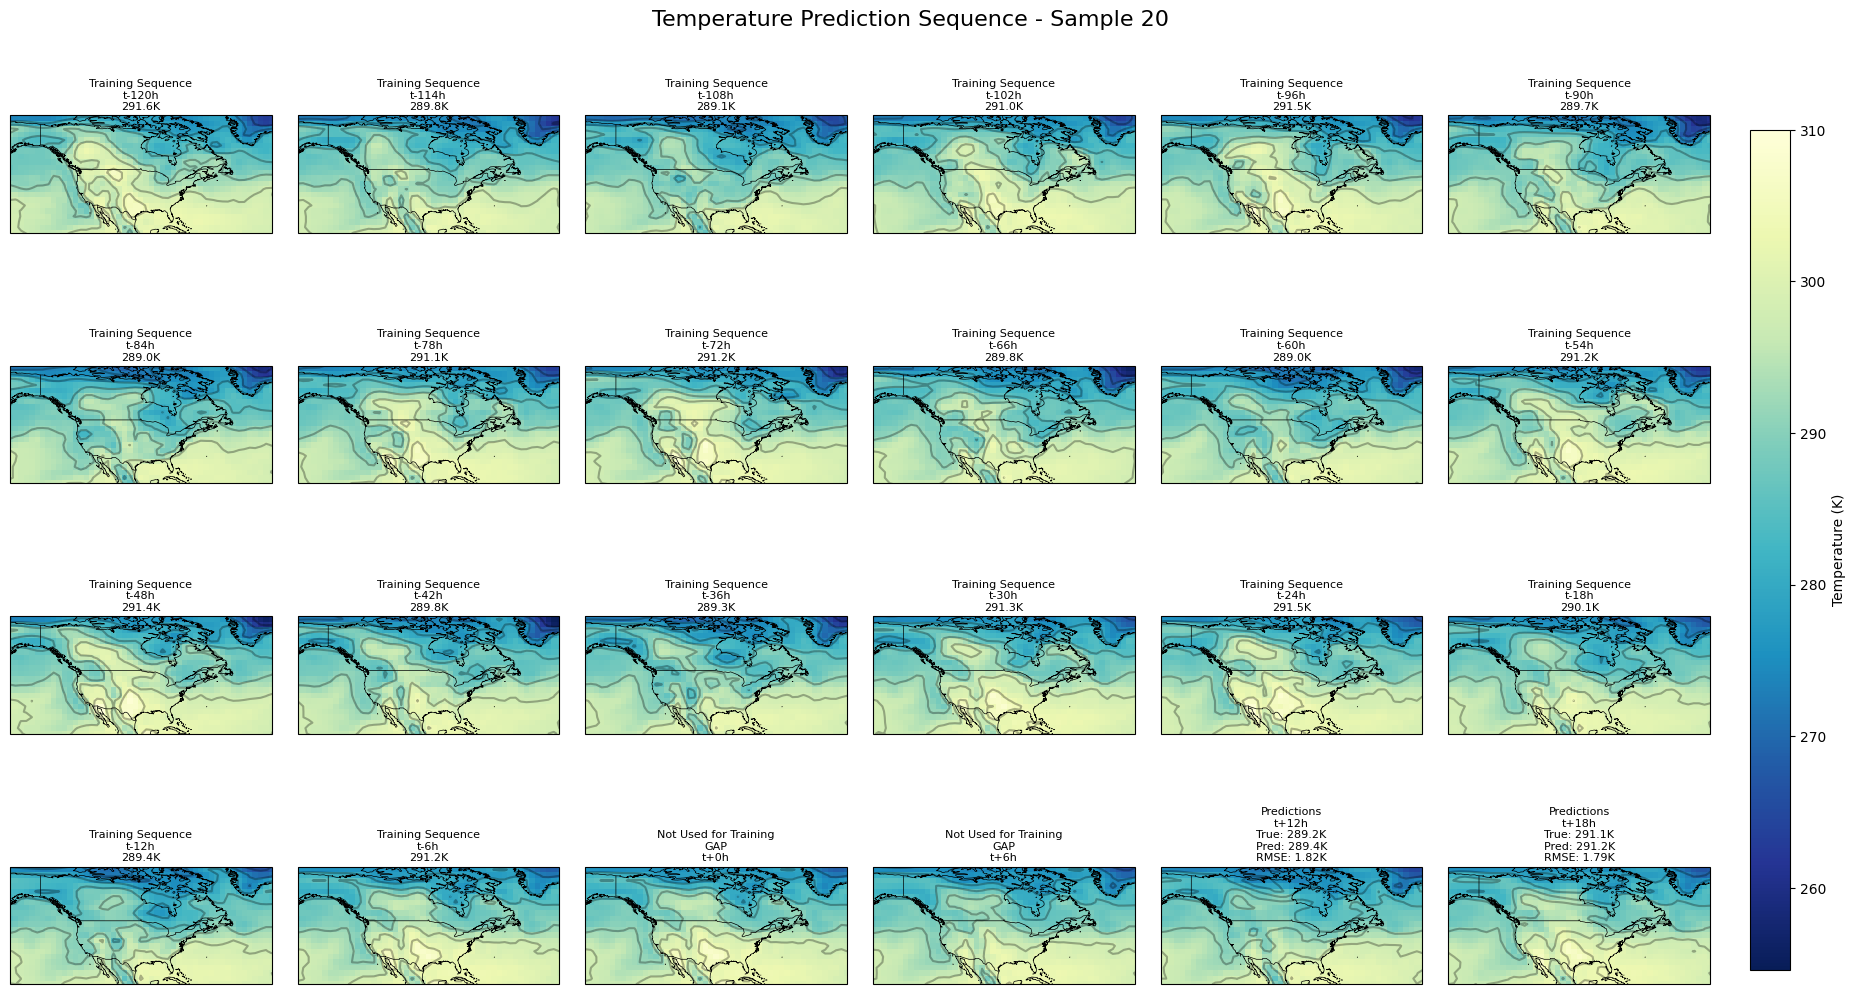

In [21]:
visualize_prediction_sequence(
    model=model,
    dataset=val_dataset,
    dataloader=val_dataloader,
    device=device,
    sample_idx=20
)